# Lab document created and seperated from the original code to make things run better. 


In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
from torchvision import transforms
from torch import nn
from torch import optim
from tqdm import tqdm
import numpy as np
import torch.nn.functional as F
from torchinfo import summary

torch.manual_seed(42)
np.random.seed(42)

In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
train_size = 0.9
lr = 1e-3
eps = 1e-8
batch_size = 256
epochs = 30

In [3]:
def train(dataloaders, model, loss_fn, optimizer, epochs, device, noisy=None, super_res=None):
    tqdm_iter = tqdm(range(epochs))
    train_dataloader, test_dataloader = dataloaders[0], dataloaders[1]

    for epoch in tqdm_iter:
        model.train()
        train_loss = 0.0
        test_loss = 0.0

        for batch in train_dataloader:
            imgs, labels = batch
            shapes = list(imgs.shape)

            if super_res is not None:
                shapes[2], shapes[3] = int(shapes[2] / super_res), int(shapes[3] / super_res)
                _transform = transforms.Resize((shapes[2], shapes[3]))
                imgs_transformed = _transform(imgs)
                imgs_transformed = imgs_transformed.to(device)

            imgs = imgs.to(device)
            labels = labels.to(device)

            if noisy is not None:
                noisy_tensor = noisy[0]
            else:
                noisy_tensor = torch.zeros(tuple(shapes)).to(device)

            if super_res is None:
                imgs_noisy = imgs + noisy_tensor
            else:
                imgs_noisy = imgs_transformed + noisy_tensor

            imgs_noisy = torch.clamp(imgs_noisy, 0., 1.)

            preds = model(imgs_noisy)
            loss = loss_fn(preds, imgs)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        model.eval()
        with torch.no_grad():
            for batch in test_dataloader:
                imgs, labels = batch
                shapes = list(imgs.shape)

                if super_res is not None:
                    shapes[2], shapes[3] = int(shapes[2] / super_res), int(shapes[3] / super_res)
                    _transform = transforms.Resize((shapes[2], shapes[3]))
                    imgs_transformed = _transform(imgs)
                    imgs_transformed = imgs_transformed.to(device)


                imgs = imgs.to(device)
                labels = labels.to(device)

                if noisy is not None:
                    test_noisy_tensor = noisy[1]
                else:
                    test_noisy_tensor = torch.zeros(tuple(shapes)).to(device)

                if super_res is None:
                    imgs_noisy = imgs + test_noisy_tensor
                else:
                    imgs_noisy = imgs_transformed + test_noisy_tensor

                imgs_noisy = torch.clamp(imgs_noisy, 0., 1.)

                preds = model(imgs_noisy)
                loss = loss_fn(preds, imgs)

                test_loss += loss.item()

        train_loss /= len(train_dataloader)
        test_loss /= len(test_dataloader)

        tqdm_dct = {'train loss:': train_loss, 'test loss:': test_loss}
        tqdm_iter.set_postfix(tqdm_dct, refresh=True)
        tqdm_iter.refresh()

In [4]:
def train_vae(dataloaders, model, optimizer, epochs, device):
    tqdm_iter = tqdm(range(epochs))
    train_dataloader, test_dataloader = dataloaders[0], dataloaders[1]

    for epoch in tqdm_iter:
        model.train()
        train_loss = 0.0
        test_loss = 0.0

        for batch in train_dataloader:
            imgs, labels = batch
            imgs = imgs.to(device)
            labels = labels.to(device)

            preds = model(imgs)
            z_vals = model.get_zvals()
            loss = vae_loss(preds, imgs, z_vals)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        model.eval()
        with torch.no_grad():
            for batch in test_dataloader:
                imgs, labels = batch
                imgs = imgs.to(device)
                labels = labels.to(device)

                preds = model(imgs)
                z_vals = model.get_zvals()
                loss = vae_loss(preds, imgs, z_vals)

                test_loss += loss.item()

        train_loss /= len(train_dataloader)
        test_loss /= len(test_dataloader)

        tqdm_dct = {'train loss:': train_loss, 'test loss:': test_loss}
        tqdm_iter.set_postfix(tqdm_dct, refresh=True)
        tqdm_iter.refresh()

In [5]:
def mnist(train_part, transform=None):
    dataset = torchvision.datasets.MNIST('.', download=True, transform=transform)
    train_part = int(train_part * len(dataset))
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_part, len(dataset) - train_part])
    return train_dataset, test_dataset

In [6]:
transform = transforms.Compose([transforms.ToTensor()])

train_dataset, test_dataset = mnist(train_size, transform)

train_dataloader = torch.utils.data.DataLoader(train_dataset, drop_last=True, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)
dataloaders = (train_dataloader, test_dataloader)

# First set of tasks as outlined in the lecture
> **Task 1**: Try to train autoencoder with very small latent vector size, eg. 2, and plot the dots corresponding to different digits. *Hint: Use fully-connected dense layer after the convoluitonal part to reduce the vector size to the required value.* 

In [7]:
# Task 1
class KeiEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=(3, 3), padding='same')
        self.maxpool1 = nn.MaxPool2d(kernel_size=(2, 2))
        self.conv2 = nn.Conv2d(16, 8, kernel_size=(3, 3), padding='same')
        self.maxpool2 = nn.MaxPool2d(kernel_size=(2, 2))
        self.conv3 = nn.Conv2d(8, 8, kernel_size=(3, 3), padding='same')
        self.maxpool3 = nn.MaxPool2d(kernel_size=(2, 2), padding=(1, 1))
        self.fc1 = nn.Linear(8*4*4, 2)
        self.relu = nn.ReLU()

    def forward(self, input):
        hidden1 = self.maxpool1(self.relu(self.conv1(input)))
        hidden2 = self.maxpool2(self.relu(self.conv2(hidden1)))
        encoded = self.maxpool3(self.relu(self.conv3(hidden2)))
        flat = encoded.view(encoded.size(0), -1)
        linear = self.fc1(flat)
        return linear
        
class KeiDecoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 8 * 4 * 4)
        self.conv1 = nn.Conv2d(8, 8, kernel_size=(3, 3), padding='same')
        self.upsample1 = nn.Upsample(scale_factor=(2, 2))
        self.conv2 = nn.Conv2d(8, 8, kernel_size=(3, 3), padding='same')
        self.upsample2 = nn.Upsample(scale_factor=(2, 2))
        self.conv3 = nn.Conv2d(8, 16, kernel_size=(3, 3))
        self.upsample3 = nn.Upsample(scale_factor=(2, 2))
        self.conv4 = nn.Conv2d(16, 1, kernel_size=(3, 3), padding='same')
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, input):
        linear = self.relu(self.fc1(input))
        linear = linear.view(linear.size(0), 8, 4, 4)
        hidden1 = self.upsample1(self.relu(self.conv1(linear)))
        hidden2 = self.upsample2(self.relu(self.conv2(hidden1)))
        hidden3 = self.upsample3(self.relu(self.conv3(hidden2)))
        decoded = self.sigmoid(self.conv4(hidden3))
        return decoded
        
class KeiAutoEncoder(nn.Module):
    def __init__(self, super_resolution=False):
        super().__init__()
        self.encoder = KeiEncoder()
        self.decoder = KeiDecoder()

    def forward(self, input):
        encoded = self.encoder(input)
        decoded = self.decoder(encoded)
        return decoded

autmodel = KeiAutoEncoder()
print(summary(autmodel,input_size=(1,1,28,28)))

encoder_path = 'saved-models/autoencoder'

##### ALready trained, downloaded
# optimizer = optim.Adam(autmodel.parameters(), lr=lr, eps=eps)
# loss_fn = nn.BCELoss()
# train(dataloaders, autmodel, loss_fn, optimizer, epochs, device)
# torch.save(autmodel.state_dict(), encoder_path)

# Load
autmodel.load_state_dict(torch.load(encoder_path))

Layer (type:depth-idx)                   Output Shape              Param #
KeiAutoEncoder                           [1, 1, 28, 28]            --
├─KeiEncoder: 1-1                        [1, 2]                    --
│    └─Conv2d: 2-1                       [1, 16, 28, 28]           160
│    └─ReLU: 2-2                         [1, 16, 28, 28]           --
│    └─MaxPool2d: 2-3                    [1, 16, 14, 14]           --
│    └─Conv2d: 2-4                       [1, 8, 14, 14]            1,160
│    └─ReLU: 2-5                         [1, 8, 14, 14]            --
│    └─MaxPool2d: 2-6                    [1, 8, 7, 7]              --
│    └─Conv2d: 2-7                       [1, 8, 7, 7]              584
│    └─ReLU: 2-8                         [1, 8, 7, 7]              --
│    └─MaxPool2d: 2-9                    [1, 8, 4, 4]              --
│    └─Linear: 2-10                      [1, 2]                    258
├─KeiDecoder: 1-2                        [1, 1, 28, 28]            --
│    └─Li

<All keys matched successfully>

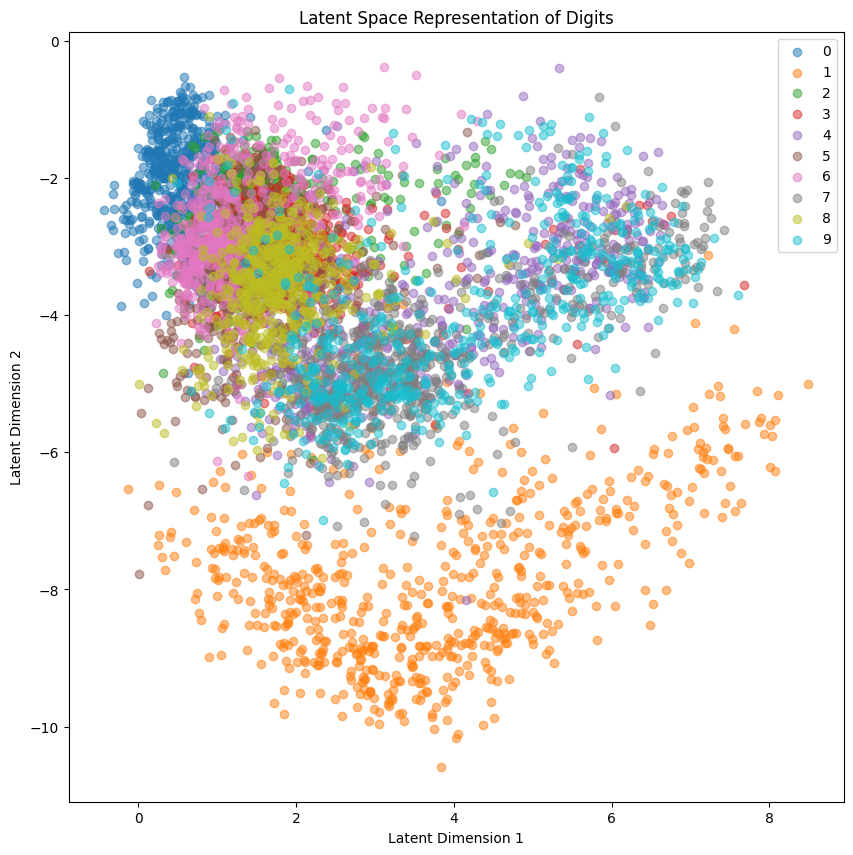

In [8]:
def plot_latent_space(model, data_loader):
    model.eval()
    latents = []
    labels = []
    with torch.no_grad():
        for data, target in data_loader:
            data = data.to(device)
            encoded = model.encoder(data)
            latents.append(encoded.cpu().numpy())
            labels.append(target.numpy())
    
    latents = np.concatenate(latents)
    labels = np.concatenate(labels)
    
    plt.figure(figsize=(10, 10))
    for i in range(10):
        indices = labels == i
        plt.scatter(latents[indices, 0], latents[indices, 1], label=str(i), alpha=0.5)
    plt.legend()
    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    plt.title('Latent Space Representation of Digits')
    plt.show()

# Plot the latent space using the test dataset
plot_latent_space(autmodel, test_dataloader)

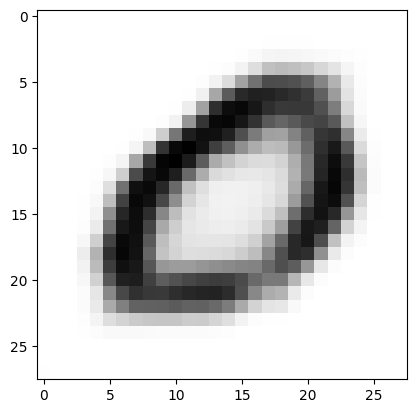

In [9]:
# Kaleb playing around
with torch.no_grad():
    new_image = autmodel.decoder(torch.tensor([[0,-2]], dtype=torch.float32).to(device))
    # [[item, item]] as the input level is 1 batch of a tensor/list with length 2 containing float values
    new_image.squeeze_(0)
    new_image.squeeze_(0)
plt.imshow(new_image.to('cpu').numpy(), cmap='binary')
plt.show()

> **Task 2**: Starting from different digits, obtain their latent space representations, and see what effect adding some noise to the latent space has on the resulting digits.


In [10]:
def get_latent_representations(model, data_loader, num_samples=10):
    model.eval()
    latents = []
    originals = []
    with torch.no_grad():
        for data, _ in data_loader:
            data = data.to('cuda')
            encoded = model.encoder(data)
            latents.append(encoded.cpu().numpy())
            originals.append(data.cpu().numpy())
            if len(latents) * data.size(0) >= num_samples:
                break
    
    latents = np.concatenate(latents)[:num_samples]
    originals = np.concatenate(originals)[:num_samples]
    return latents, originals
latents, originals = get_latent_representations(autmodel, test_dataloader, num_samples=10)


In [11]:
def add_noise(latents, noise_level=0.1):
    noisy_latents = latents + np.random.normal(0, noise_level, latents.shape)
    return noisy_latents

# Add noise to the latent representations
noise_level = 0.1
noisy_latents = add_noise(latents, noise_level)

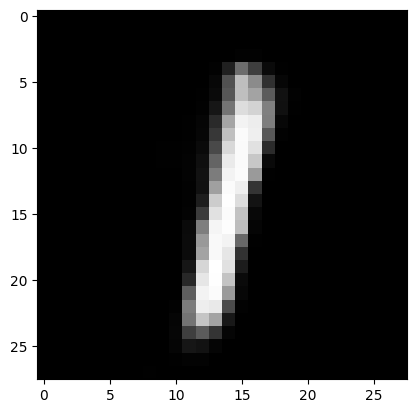

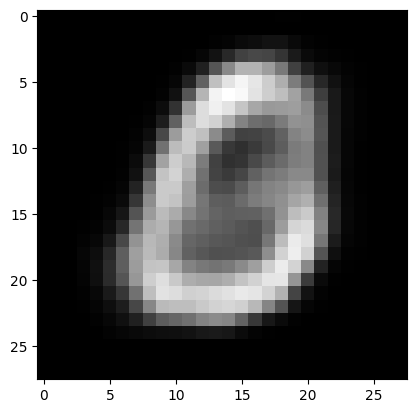

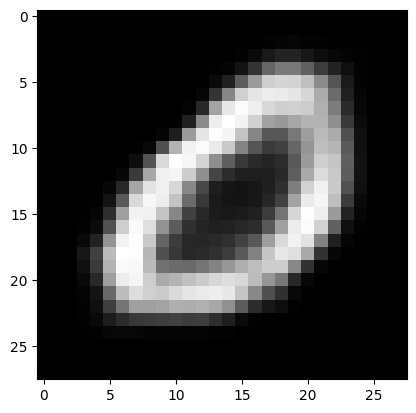

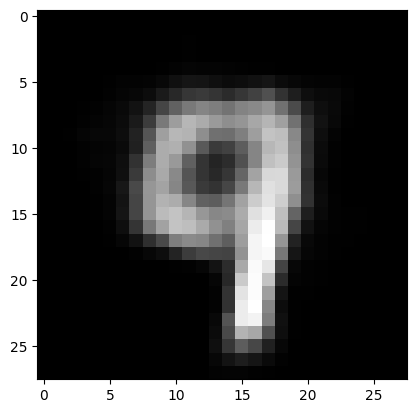

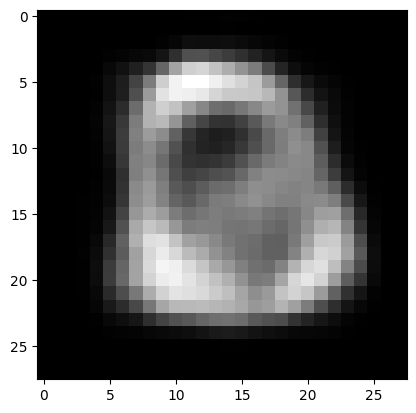

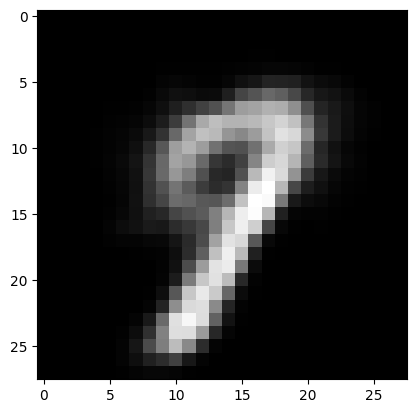

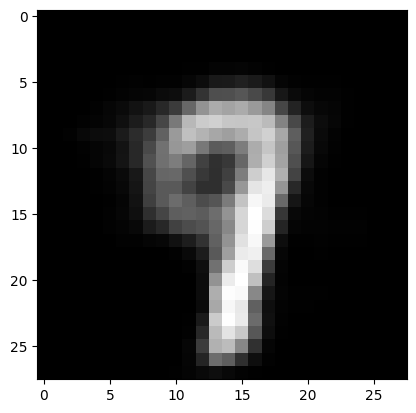

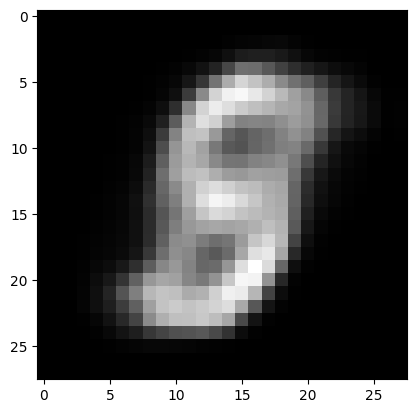

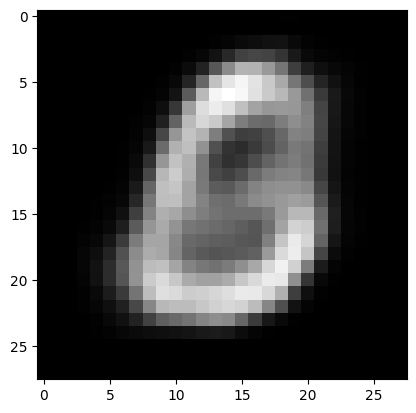

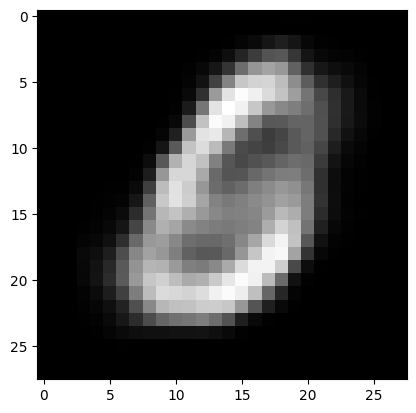

In [12]:
with torch.no_grad():
    noise_images = autmodel.decoder(torch.tensor(noisy_latents, dtype=torch.float32).to(device))
    # [[item, item]] as the input level is 1 batch of a tensor/list with length 2 containing float values
    noise_images.squeeze_(0)
    noise_images.squeeze_(0)
for img in noise_images:
    arr_img = np.array(img.to('cpu'), dtype='float')
    pixels = arr_img.reshape((28, 28))
    plt.imshow(pixels, cmap='gray')
    plt.show()

> **Task**: In our sample, we have trained fully-connected VAE. Now take the CNN from traditional auto-encoder above and create CNN-based VAE.

In [13]:
class CNNVAEEncoder(nn.Module):
    def __init__(self, device):
        super().__init__()
        self.intermediate_dim = 64*4*4
        self.latent_dim = 2
        self.conv1 = nn.Conv2d(1, 32, kernel_size=(3, 3), padding='same')
        self.maxpool1 = nn.MaxPool2d(kernel_size=(2, 2))
        self.conv2 = nn.Conv2d(32, 64, kernel_size=(3, 3), padding='same')
        self.maxpool2 = nn.MaxPool2d(kernel_size=(2, 2))
        self.conv3 = nn.Conv2d(64, 64, kernel_size=(3, 3), padding='same')
        self.maxpool3 = nn.MaxPool2d(kernel_size=(2, 2), padding=(1,1))
        self.z_mean = nn.Linear(self.intermediate_dim, self.latent_dim)
        self.z_log = nn.Linear(self.intermediate_dim, self.latent_dim)
        self.relu = nn.ReLU()
        self.device = device

    def forward(self, input):
        hidden1 = self.maxpool1(self.relu(self.conv1(input)))
        hidden2 = self.maxpool2(self.relu(self.conv2(hidden1)))
        hidden3 = self.maxpool3(self.relu(self.conv3(hidden2)))
        flat = hidden3.view(hidden3.size(0), -1)
        
        z_mean = self.z_mean(flat)
        z_log = self.z_log(flat)
        eps = (torch.randn(z_mean.size(0), z_mean.size(1)).to(z_mean.get_device())).to(device)
        z_val = z_mean + torch.exp(z_log) * eps
        return z_mean, z_log, z_val

In [14]:
class CNNVAEDecoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.intermediate_dim = 64*4*4
        self.latent_dim = 2
        self.fc1 = nn.Linear(self.latent_dim, self.intermediate_dim)
        self.conv1 = nn.Conv2d(64, 64, kernel_size=(3, 3), padding='same')
        self.upsample1 = nn.Upsample(scale_factor=(2,2))
        self.conv2 = nn.Conv2d(64, 64, kernel_size=(3, 3), padding='same')
        self.upsample2 = nn.Upsample(scale_factor=(2, 2))
        self.conv3 = nn.Conv2d(64, 32, kernel_size=(3, 3))
        self.upsample3 = nn.Upsample(scale_factor=(2, 2))
        self.conv4 = nn.Conv2d(32, 1, kernel_size=(3, 3), padding='same')
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, input):
        linear = self.relu(self.fc1(input))
        linear = linear.view(linear.size(0), 64, 4, 4)
        hidden1 = self.upsample1(self.relu(self.conv1(linear)))
        hidden2 = self.upsample2(self.relu(self.conv2(hidden1)))
        hidden3 = self.upsample3(self.relu(self.conv3(hidden2)))
        decoded = self.sigmoid(self.conv4(hidden3))
        return decoded

In [15]:
class CNNVAEAutoEncoder(nn.Module):
    def __init__(self, device):
        super().__init__()
        self.encoder = CNNVAEEncoder(device)
        self.decoder = CNNVAEDecoder()
        self.z_vals = None

    def forward(self, input):
        # bs, c, h, w = input.shape[0], input.shape[1], input.shape[2], input.shape[3]
        # input = input.view(bs, -1)
        encoded = self.encoder(input)
        self.z_vals = encoded
        decoded = self.decoder(encoded[2])
        return decoded
    
    def get_zvals(self):
        return self.z_vals
cnnmodel = CNNVAEAutoEncoder(device)
print(summary(cnnmodel,input_size=(1,1,28,28)))

Layer (type:depth-idx)                   Output Shape              Param #
CNNVAEAutoEncoder                        [1, 1, 28, 28]            --
├─CNNVAEEncoder: 1-1                     [1, 2]                    --
│    └─Conv2d: 2-1                       [1, 32, 28, 28]           320
│    └─ReLU: 2-2                         [1, 32, 28, 28]           --
│    └─MaxPool2d: 2-3                    [1, 32, 14, 14]           --
│    └─Conv2d: 2-4                       [1, 64, 14, 14]           18,496
│    └─ReLU: 2-5                         [1, 64, 14, 14]           --
│    └─MaxPool2d: 2-6                    [1, 64, 7, 7]             --
│    └─Conv2d: 2-7                       [1, 64, 7, 7]             36,928
│    └─ReLU: 2-8                         [1, 64, 7, 7]             --
│    └─MaxPool2d: 2-9                    [1, 64, 4, 4]             --
│    └─Linear: 2-10                      [1, 2]                    2,050
│    └─Linear: 2-11                      [1, 2]                    2,050


In [100]:
# Used with old, non covolutional VAE.
# def vae_loss(preds, targets, z_vals):
#     mse = nn.MSELoss()
#     reconstruction_loss = mse(preds, targets.view(targets.shape[0], -1)) * 784.0
#     temp = 1.0 + z_vals[1] - torch.square(z_vals[0]) - torch.exp(z_vals[1])
#     kl_loss = -0.5 * torch.sum(temp, axis=-1)
#     return torch.mean(reconstruction_loss + kl_loss)

# Edited to maximize the CNN VAE's capabilities to work with 2D input
def vae_loss(preds, targets, z_vals):
    mse = nn.MSELoss()
    reconstruction_loss = mse(preds, targets)
    temp = 1.0 + z_vals[1] - torch.square(z_vals[0]) - torch.exp(z_vals[1])
    kl_loss = -0.5 * torch.sum(temp, axis=-1)
    return torch.mean(reconstruction_loss + kl_loss)


lr = 2.5e-3
eps = 1e-8
train_size = 0.9
batch_size = 64
epochs = 30
train_dataloader = torch.utils.data.DataLoader(train_dataset, drop_last=True, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)
dataloaders = (train_dataloader, test_dataloader)

In [101]:
cnnmodel = CNNVAEAutoEncoder(device).to(device)
optimizer = optim.RMSprop(cnnmodel.parameters(), lr=lr, eps=eps)

In [102]:
train_vae(dataloaders, cnnmodel, optimizer, epochs, device)

100%|███████████████████████████████████| 30/30 [18:14<00:00, 36.48s/it, train loss:=0.112, test loss:=0.112]


In [31]:
def plotn(n, data, noisy=False, super_res=None):
    fig, ax = plt.subplots(1, n)
    for i, z in enumerate(data):
        if i == n:
            break
        preprocess = z[0].reshape(1, 28, 28) if z[0].shape[1] == 28 else z[0].reshape(1, 14, 14) if z[0].shape[1] == 14 else z[0]
        if super_res is not None:
            _transform = transforms.Resize((int(preprocess.shape[1] / super_res), int(preprocess.shape[2] / super_res)))
            preprocess = _transform(preprocess)

        if noisy:
            shapes = list(preprocess.shape)
            preprocess += noisify(shapes)

        ax[i].imshow(preprocess[0])
    plt.show()

(64, 1, 28, 28)


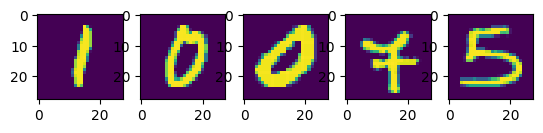

64


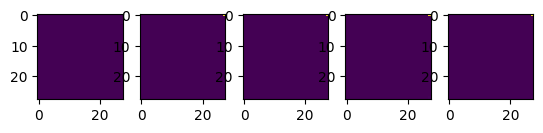

In [103]:
cnnmodel.eval()
predictions = []
plots = 5

for batch in train_dataloader:
    
    imgs, labels = batch
    print(np.asarray(imgs).shape)
    imgs = imgs.to(device)
    labels = labels.to(device)

    
    predictions = cnnmodel(imgs).cpu().detach().numpy()
    break

    
plotn(plots, test_dataset)
print(len(predictions))
plotn(plots, predictions)